In [1]:
import sys
sys.path.append("scripts/")
from Environment import*

In [2]:
class IdealRobot:
    def __init__(self, pose, agent=None, sensor=None, color="black"):
        self.pose = pose
        self.r = 0.4
        self.color = color
        self.agent = agent
        self.poses = [pose]
        self.sensor = sensor
    
    def draw(self, ax, elems):
        x, y, theta = self.pose
        xn = x + self.r * math.cos(theta) 
        yn = y + self.r * math.sin(theta) 
        elems += ax.plot([x,xn], [y,yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color) 
        elems.append(ax.add_patch(c))
        
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
        if self.sensor:
            self.sensor.draw(ax, elems, self.poses[-2])
        if self.agent and hasattr(self.agent, "draw"):
            self.agent.draw(ax, elems, self.r)
    
    def state_transition(self, nu, omega, time, pose):
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), nu*math.sin(t0), omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)), omega*time ] )

    def one_step(self, time_interval):
        if not self.agent: return
        obs, pos = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs, pos)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)

In [3]:
class Agent:
    def __init__(self, velocity=np.array([1.0, 10/180*np.pi]), nu_limit=[-1.0, 1.0], omega_limit=[-20/180*math.pi, 20/180*math.pi]):
        self.nu = velocity[0]
        self.omega = velocity[1]
        self.nu_min, self.nu_max = nu_limit
        self.omega_min, self.omega_max = omega_limit
        self.position = None
        
    def decision(self, observation=None, position=None):
        self.limitVelocity()
        self.position = position
        return self.nu, self.omega
    
    def limitVelocity(self):
        self.nu = self.nu_min if self.nu <= self.nu_min else self.nu
        self.nu = self.nu_max if self.nu >= self.nu_max else self.nu
        self.omega = self.omega_min if self.omega <= self.omega_min else self.omega
        self.omega = self.omega_max if self.omega >= self.omega_max else self.omega
    
    def draw(self, ax, elems, r):
        if self.position is not None:
            elems += ax.plot(
                [self.position[0]+r*math.cos(self.position[2]), self.position[0]+(r+self.nu)*math.cos(self.position[2])],
                [self.position[1]+r*math.sin(self.position[2]), self.position[1]+(r+self.nu)*math.sin(self.position[2])],
                color="cyan"
            )

In [4]:
class IdealCamera:
    def __init__(self, env_map, distance_range=(0.5, 6.0), direction_range=(-math.pi/3, math.pi/3)):
        self.map = env_map
        self.lastdata = []
        
        self.distance_range = distance_range
        self.direction_range = direction_range
        
    def visible(self, polarpos):
        if polarpos is None:
            return False
        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1] and self.direction_range[0] <= polarpos[1] <= self.direction_range[1]
        
    def data(self, cam_pose):
        observed = []
        for lm in self.map.obstacles:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):
                observed.append((z, lm.id))
            
        self.lastdata = observed
        pos = self.getPosition(cam_pose)
        return observed, pos
    
    def getPosition(self, obj_pos):
        return np.array([obj_pos[0], obj_pos[1], obj_pos[2]]).T
    
    def observation_function(self, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - cam_pose[2]
        while phi >= np.pi: phi -= 2 * np.pi
        while phi < -np.pi: phi += 2 * np.pi
        return np.array([np.hypot(*diff), phi]).T
    
    def draw(self, ax, elems, cam_pose):
        '''
        for lm in self.lastdata:
            x, y, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([x, lx], [y, ly], color="pink")
        '''

<IPython.core.display.Javascript object>


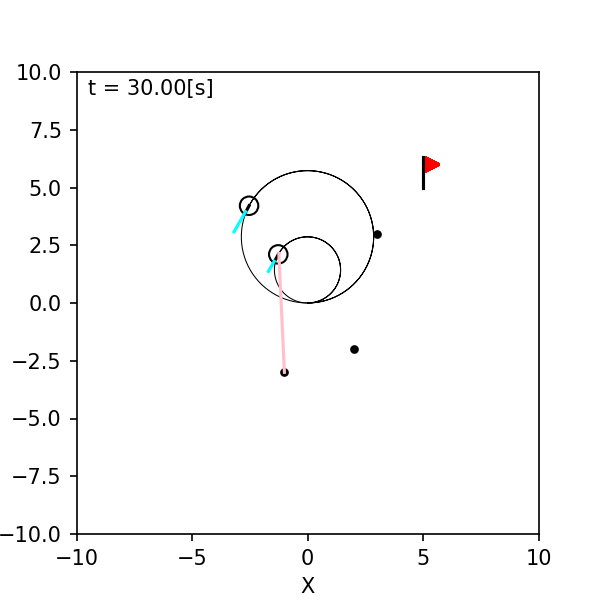

In [5]:
if __name__ == "__main__":
    time_span = 30
    time_interval = 0.1
    
    goal = [5, 5]
    map_size = [10, 10]
    
    world = World(30, 0.1, debug=False, map_size=map_size)

    m = Map(goal=goal, map_size=map_size)
    m.append_obstacle(Obstacle(2, -2))
    m.append_obstacle(Obstacle(-1, -3))
    m.append_obstacle(Obstacle(3, 3))
    world.append(m)
    
    circling1 = Agent(np.array([1.0, 20/180*np.pi]))
    circling2 = Agent(np.array([0.5, 20/180*np.pi]))
    robot1 = IdealRobot(np.array([0, 0, 0]), circling1, IdealCamera(m))
    robot2 = IdealRobot(np.array([0, 0, 0]), circling2, IdealCamera(m))
    world.append(robot1)
    world.append(robot2)
    
    world.draw()